In [153]:
import math 
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

## Value Class

In [290]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

## Drawing Computational Graph

In [34]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [291]:
# Inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# Weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias 
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh();o.label = 'o'
o.backward()

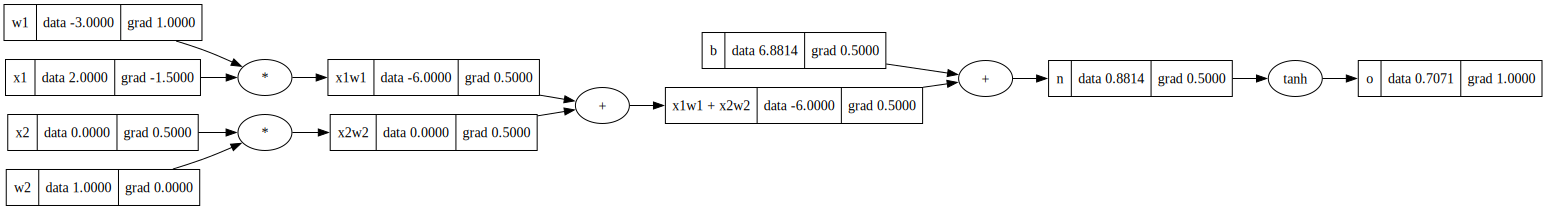

In [292]:
draw_dot(o)

## Breaking up TanH

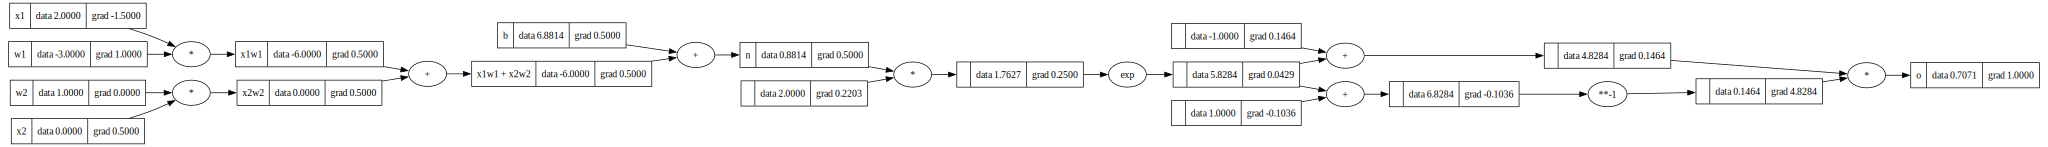

In [293]:
# Inputs
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# Weights
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias 
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# -------------------
e = (2*n).exp()
o = (e-1) / (e+1)
o.label = 'o'
o.backward()
draw_dot(o)

## Same procedure in Pytorch

In [294]:
import torch 

x1 = torch.tensor(2.0, requires_grad=True)
x2 = torch.tensor(0.0, requires_grad=True)
w1 = torch.tensor(-3.0, requires_grad=True)
w2 = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(6.8813735870195432, requires_grad=True)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print("-------------------")
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071067094802856
-------------------
x2 0.5000001192092896
x1 -1.5000003576278687
w1 1.000000238418579
w2 0.0


## MLP

In [297]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]
    

## Computational Graph NLP (without Grads)

In [298]:
# Initialize the model
X = [2.0, 3.0, -1]
n = MLP(3, [4,4,1])
n(X)

Value(data=-0.09974404130202606)

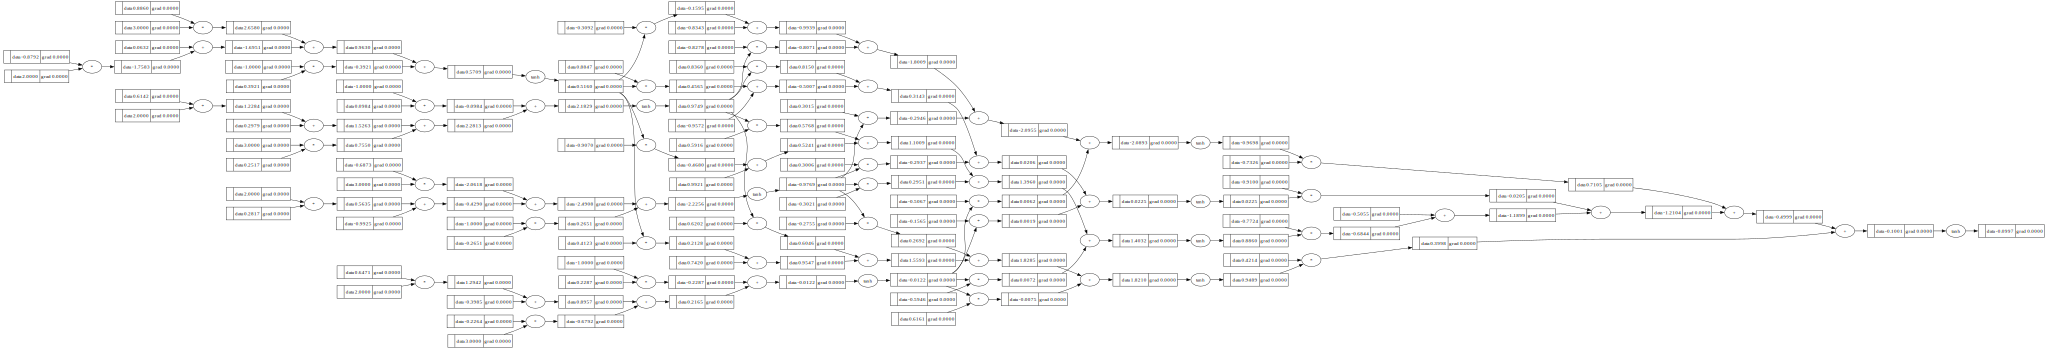

In [299]:
draw_dot(n(X))

## Example Data

In [300]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

### Loss Function

In [301]:
for k in range(20): 
    # forward pass
    y_preds = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for yout, ygt in zip(y_preds, ys)])
    
    # zero grad 
    for p in n.parameters(): 
        p.grad = 0.0
    # backward pass 
    loss.backward()
    
    for p in n.parameters(): 
        p.data += -0.1 *p.grad

    print(k, loss.data)

0 4.768402506045092
1 3.124013751047931
2 2.923049633201349
3 4.882424123323695
4 5.884476120127198
5 2.4451770206677783
6 4.980768611279636
7 1.1873120314839078
8 0.7591566504155604
9 0.06534776175220554
10 0.05788300930682509
11 0.052878324683646026
12 0.04898597924400914
13 0.045750328987281125
14 0.0429689950847778
15 0.04053180434316191
16 0.03836922469072755
17 0.036432762299975274
18 0.034686334199069684
19 0.03310194045655131


In [261]:
y_preds

[Value(data=0.9228722595043668),
 Value(data=-0.9820806934494316),
 Value(data=-0.8682793204715664),
 Value(data=0.8768421906900397)]

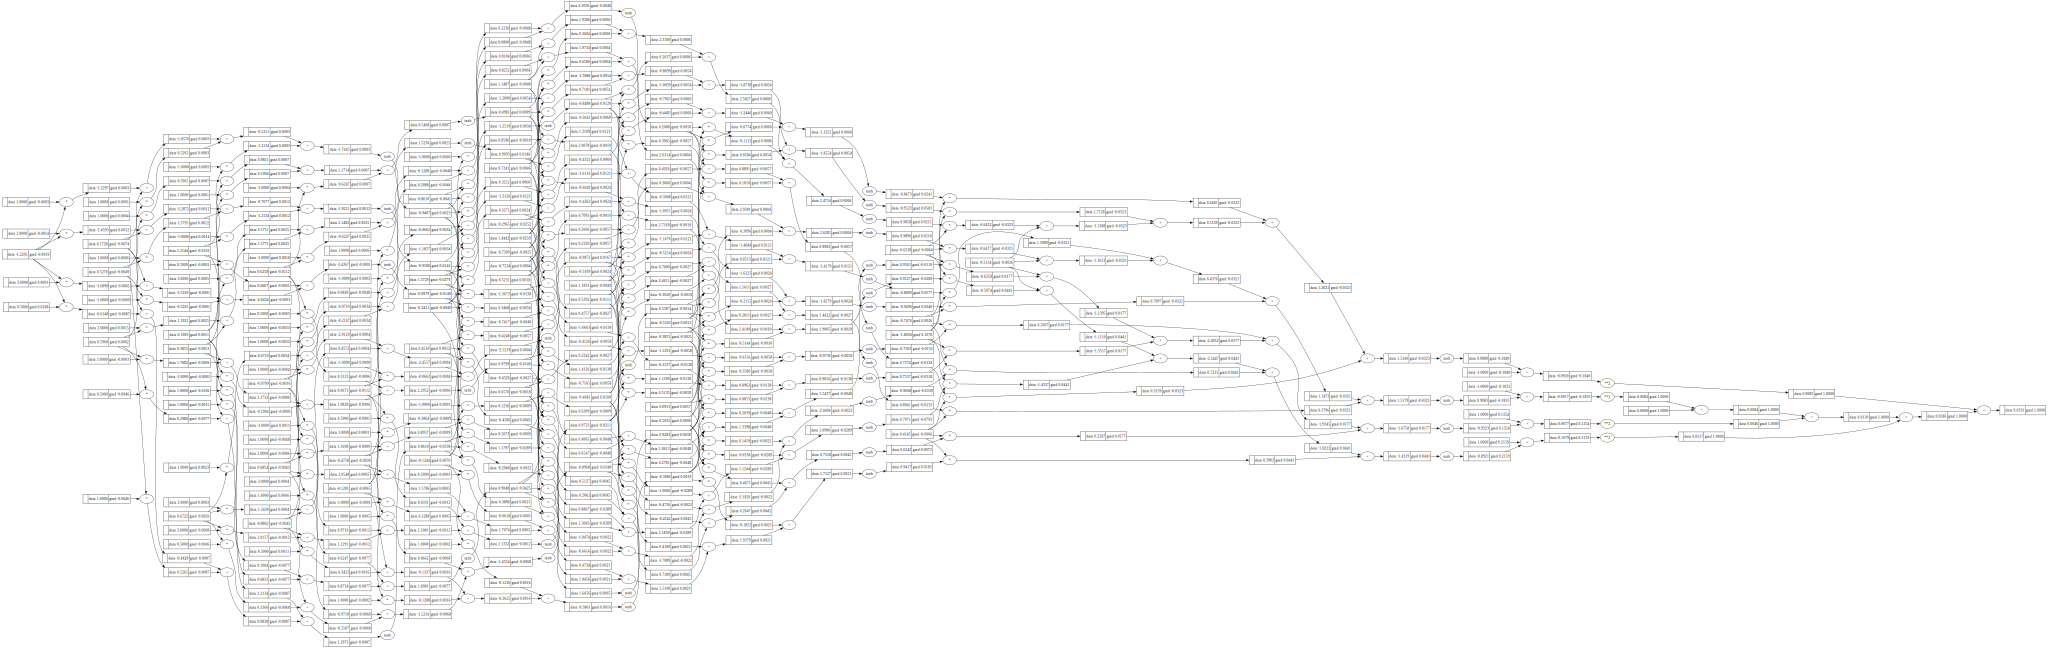

In [302]:
draw_dot(loss)